# Описание проекта

В данной проектной работе исследуется датасет с данными об объектах недвижимости Санкт-Петербурга и Ленинградской области. Задача проекта- исследовать исходные данные, определить основные рыночные параметры квартир (например - стоимость за квадратный метр) и на основе полученных данных - подтвердить или опровергнуть гипотезы о зависимости стоимости квартиры от основных параметров жилья (площадь квартиры, количество комнат, удаленность от центра). Также необходимо найти центральную зону Санкт-Петербурга и подтвердить либо опровергнуть поставленную гипотезу и в этой зоне.

# Предобработка данных
## Обработка пропусков

Откроем датафрейм и при помощи метода `info()` изучим информацию о датафрейме: 

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Как видно, в нашем датафрейме 23699 строк и 22 колонки. Названия колонок соответствуют правилам наименования колонок, здесь все ОК. В части колонок имеются пропуски, рассмотрим каждую колонку с пропусками детально. 
<a id='info'></a>

In [2]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Колонка `ceiling_height`
Посмотрим уникальные значения в колонке ceiling_height и посчитаем количество пропусков. Как видно, количество пропусков значительное (9195 строк из 23699, т.е. практически 1/3 от всех значений), если мы удалим строки с пропусками- исследование потеряет большое количество данных и будет нерелевантным. Заменим пропущенные значения высоты потолка на медианное значение по таблице (т.к. это количественная переменная, среднее значение в связи с большим количеством пропусков будет некорректно высоким). 

In [3]:
print(data['ceiling_height'].value_counts())
len(data[data['ceiling_height'].isna() == True])

2.50     3515
2.60     1646
2.70     1574
3.00     1112
2.80      993
         ... 
4.25        1
3.39        1
3.93        1
10.30       1
4.65        1
Name: ceiling_height, Length: 183, dtype: int64


9195

Перед заполнением пропусков проверим, есть ли аномально маленькие или большие значения высоты потолка, зададим запрос на высоту потолка до 2,0 м. и выше 5,0 м. 

Видим, что запрос выдал 39 строк по данному запросу. 
Что я могу сказать: 
- строки с высотой потолка до 1.20 м. включительно, 100 м., а также в диапазоне от 8.0 м. до 22.60 - удалим как аномальные. Думаю, здесь имеет место ошибка заполнения. 
- строки от 24.0 до 32.0 м - думаю, здесь имеет место ошибка заполнения и речь идет о потолках 2.40-3.20 м. 

Исправим неверно заполненные строки, заполним пропуски медианным значением и удалим аномально высокие или низкие значения высоты потолка: 
<a id='celling'></a>

In [4]:
data.query('ceiling_height < 2.0 or ceiling_height > 5.0').sort_values(by = 'ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22590,16,6000000.0,55.0,2018-10-31T00:00:00,2,1.00,12.0,32.4,7,NaN,...,10.00,NaN,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,NaN,...,5.20,NaN,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,...,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
464,15,66571000.0,280.3,2015-06-11T00:00:00,6,5.20,8.0,159.5,7,NaN,...,21.10,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
12628,14,3900000.0,50.0,2018-03-29T00:00:00,1,5.30,5.0,NaN,5,NaN,...,NaN,NaN,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.30,3.0,190.0,3,NaN,...,63.00,2.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
7578,17,38000000.0,143.0,2017-11-02T00:00:00,3,5.50,5.0,83.0,5,NaN,...,29.00,1.0,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN
1388,20,59800000.0,399.0,2015-01-21T00:00:00,5,5.60,6.0,NaN,6,NaN,...,NaN,0.0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
21227,0,8200000.0,71.0,2017-07-21T00:00:00,0,5.80,5.0,68.0,5,NaN,...,NaN,0.0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0
20264,17,119000000.0,187.6,2017-07-10T00:00:00,4,6.00,7.0,147.0,7,NaN,...,15.60,NaN,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0


Напишем функцию `celling`, которая уменьшит значение потолка, попадающее в диапазон от 24.0 до 32.0 м., применим к столбцу **ceiling_height** и перезапишем датасет, убрав при помощи запроса `query` слишком малые или слишком большие значения, о которых указано [выше](#celling) 

In [5]:
def celling (ceiling_height):
    if 24.0 <= ceiling_height <= 32.0:
        return ceiling_height * 0.1
    else:
        return ceiling_height

In [6]:
data['ceiling_height'] = data['ceiling_height'].apply(celling)

In [7]:
print(data['ceiling_height'].median()) #найдем медианное значение высоты потолков
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['ceiling_height'].isna().sum() #Проверим, остались ли пропуски

2.65


0

In [8]:
data = data.query('1.50 < ceiling_height < 7.90')

In [9]:
data.query('ceiling_height < 1.5 or ceiling_height > 8.0').sort_values(by = 'ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Как видно из последнего запроса, аномальные значения потолка с высотой ниже 1.50 м. и выше 8.0 м. - отсутствуют. Медианная высота потолка- 2.65 м., что вполне соответсвует стандарту. Пропуски заполнены, переходим к следующим колонкам.

### Колонки: `floors_total` ,  `living_area`, `kitchen_area` 
Посмотрим, сколько пропущенных значений в колонках **floors_total**, **living_area**, **kitchen_area**.
Видно, что количество пропусков значительное (по колонке **kitchen_area** и  **living_area** - количество доходит до 10% от общего количества строк). 
Т.к. эти параметры не поддаются стандартизации, заполнить медианными значениями не получится. 
Поэтому строки с пропусками в колонке **floors_total** <a id='floors_total'></a> - будем удалять, строки с пропусками в колонках **living_area** и **kitchen_area** посмотрим отдельно: 

In [10]:
print(data['floors_total'].isna().sum())
print(data['living_area'].isna().sum())
data['kitchen_area'].isna().sum()

86
1903


2276

Сделаем запрос и выведем строки, где не заполнены сразу оба параметра: **kitchen_area** и **living_area**, такие строки предлагаю убирать сразу как неинформативные, т.к. жилая площадь и площадь кухни - это основополагающие параметры каждой квартиры, без них анализ будет неточный. 

Видим, что таких строк в датасете 1464 и в них немало пропусков. Удалим их и подумаем, что делать с оставшимися пропусками. 

In [11]:
len(data[data['living_area'].isnull()].query('kitchen_area != kitchen_area'))

1464

In [12]:
data[data['living_area'].isnull()].query('kitchen_area != kitchen_area').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,2.65,9.0,NaN,2,NaN,...,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,...,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,NaN,3,NaN,...,NaN,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,2.65,13.0,NaN,13,NaN,...,NaN,NaN,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0


In [13]:
data = data.query('not(kitchen_area != kitchen_area and living_area != living_area)')

In [14]:
data[data['living_area'].isnull()].query('kitchen_area != kitchen_area').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [15]:
data[data['kitchen_area'].isnull()].sort_values(by = 'living_area').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
21758,0,2330000.0,23.00,2018-01-01T00:00:00,0,2.65,24.0,2.0,22,NaN,...,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
17582,11,2680000.0,22.00,2018-08-11T00:00:00,0,2.65,25.0,5.0,8,NaN,...,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
4542,12,3300000.0,18.00,2018-11-07T00:00:00,1,3.50,5.0,9.0,2,NaN,...,NaN,NaN,Санкт-Петербург,25157.0,4948.0,2.0,349.0,1.0,963.0,9.0
8886,10,2450000.0,15.50,2018-08-22T00:00:00,0,2.65,5.0,10.0,2,NaN,...,NaN,NaN,Санкт-Петербург,24326.0,4589.0,0.0,NaN,1.0,446.0,27.0
7700,10,3001767.0,35.29,2018-10-01T00:00:00,1,2.65,5.0,10.0,4,NaN,...,NaN,NaN,Санкт-Петербург,47204.0,25767.0,1.0,297.0,1.0,465.0,145.0


Как видим, есть пропущенные значения в столбце **kitchen_area** при наличии данных в **living_area**. Предполагаю, что мы имеем дело с квартирами-студиями (при малой жилой площади) или квартирами с открытой планировкой (при большой жилой площади)- т.е. отсутствие кухни как отдельного помещения при наличии отдельной неогороженной кухонной зоны. 
Заменим оставшиеся пропуски в колонке **kitchen_area** на нулевые значения. 

In [16]:
data['kitchen_area'] = data['kitchen_area'].fillna(0)

Проверим, остались ли пропуски в **living_area** - как видим, остались в количестве 439 шт, что составляет около 2% от всего количества строк. Повторюсь, что считаю этот параметр крайне важным для исследования, поэтому удалим данные с пропусками в **living_area** как некорректные. Также удалим пропуски в столбце **floors_total**, о чем писали [ранее](#floors_total) и проверим, не осталось ли пропусков.

In [17]:
print(data['living_area'].isna().sum())

439


In [18]:
data = data.dropna(subset = ['floors_total', 'living_area'])

In [19]:
print(data['floors_total'].isna().sum())
print(data['living_area'].isna().sum())
data['kitchen_area'].isna().sum()

0
0


0

### Колонки:  `is_apartment`, `balcony`
Посмотрим количество пропусков в столбцах **is_apartment** и **balcony**. Как видим, пропуски имеются, причем в столбце **balcony** - около 50% от всех строк. Удалять такое большое количество данных- неверно, поэтому посчитаем, что если в объявлении не указано количество балконов- значит, балкон в квартире отсутствует. То же самое- со столбцом **is_apartment**: если значение пропущено, значит это не апартаменты. Заполним пропуски значениями `False` - для **is_apartment** и `0` - для **balcony**

In [20]:
print(data['is_apartment'].value_counts())
data['is_apartment'] = data['is_apartment'].fillna(False)

False    2612
True       41
Name: is_apartment, dtype: int64


In [21]:
print(data['balcony'].isna().sum())
data['balcony'] = data['balcony'].fillna(0)

10085


### Колонка `locality_name`

Рассмотрим колонку **locality_name** на наличие пропусков. 
Видно, что в колонке локации 43 пропуска. Удалим эти данные, т.к. мы не сможем далее исследовать эти строки из-за отсутствия привязки к локации **locality_name**. 

In [22]:
print(data['locality_name'].isna().sum())

43


In [23]:
data = data.dropna(subset = ['locality_name'])

Проверим, есть ли неявные дубликаты в данной колонке: 

In [24]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'село Путилово', 'Ивангород', 'Мурино',
       'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское', 'Зеленогорск',
       'Сосновый Бор',

Вижу неявные дубликаты среди поселений "Кудрово", "Мурино" и "поселок Бугры". 
Напишем функцию, которая приведет эти наименования к единому виду. 

In [25]:
def replace_location (wrong_values, correct_value):
    for wrong_value in wrong_values:
        data['locality_name'] = data['locality_name'].replace(wrong_value, correct_value)   

In [26]:
data.query('locality_name == "посёлок Бугры"').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
372,4,3244000.0,35.86,2018-03-22T00:00:00,1,2.65,12.0,17.00,2,False,...,9.60,0.0,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,7.0
537,4,5360000.0,58.12,2018-05-07T00:00:00,2,2.65,12.0,30.89,5,False,...,12.88,2.0,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,112.0
804,7,2650000.0,26.50,2019-01-14T00:00:00,1,2.65,25.0,14.00,19,False,...,6.40,0.0,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286,2,2770000.0,31.60,2018-11-21T00:00:00,1,2.65,17.0,14.45,12,False,...,8.31,0.0,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,27.0
1588,3,1900000.0,21.89,2018-11-01T00:00:00,1,2.65,19.0,10.93,17,False,...,0.00,0.0,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,22.0


Создадим список из неверных имен и заменим их на корректные, а затем проверим, отработала ли функция:

In [27]:
replace_names_1 = ['Кудрово', 'деревня Кудрово']
name_1 = 'Кудрово'
replace_names_2 = ['поселок Мурино', 'посёлок Мурино', 'Мурино']
name_2 = 'Мурино'
replace_names_3 = ['поселок Бугры', 'посёлок Бугры']
name_3 = 'посёлок Бугры'
replace_location(replace_names_1, name_1)
replace_location(replace_names_2, name_2)
replace_location(replace_names_3, name_3)

In [28]:
data.query('locality_name == "деревня Кудрово"').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Для удобства будущей работы распределим данные в столбце **locality_name** по 3м подгруппам: 
- город (Санкт-Петербург)
- пригороды (ближайшие пригороды СПб)
- область (города и поселения в ЛО)

Для этого сделаем выборку по 15 наиболее распостраненным локациям, не включая Санкт-Петербург, удалим населенные пункты, которые относятся к Ленинградской области и не являются пригородами Санкт-Петербурга и напишем функцию, которая распределит строки по категориям. 
Понятно, что данные, где не указана локация, попадут в категорию область, будем иметь это в виду при дальнейшем исследовании. Если при далее эти данные будут выбиваться- удалим их. 

In [29]:
locality_area = data.query('locality_name != "Санкт-Петербург"')['locality_name'].value_counts().head(15)
locality_area

Мурино                     524
Кудрово                    422
посёлок Шушары             403
Всеволожск                 371
Пушкин                     345
Колпино                    328
посёлок Парголово          301
Гатчина                    292
Петергоф                   197
Выборг                     193
Сестрорецк                 168
Красное Село               166
деревня Новое Девяткино    137
Сертолово                  136
Ломоносов                  130
Name: locality_name, dtype: int64

Из этого списка я вижу, что не относятся к пригородам только Гатчина и Выборг, удалим их из `locality_area`. Напишем функцию, которая рассортирует данные из столбца **locality_name** на 3 новые категории и создаст новый столбец **area**:

In [30]:
del(locality_area['Гатчина'])
del(locality_area['Выборг'])

In [31]:
def locality(locality_name):
    if 'Санкт' in locality_name:
        return 'город'
    if locality_name in locality_area:
        return 'пригород'
    if locality_name != locality_name:  #вариант на случай ошибки
        return 'прочее'
    return 'область'

In [32]:
data['area'] = data['locality_name'].apply(locality)
data['area'].value_counts()

город       14526
пригород     3628
область      3535
Name: area, dtype: int64

In [33]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,город
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,False,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,пригород
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,False,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,город
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,...,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,город
5,10,2890000.0,30.4,2018-09-10T00:00:00,1,2.65,12.0,14.4,5,False,...,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,область


Проверим при помощи запроса, какие значения вошли в пригороды и убедимся, что все сделано верно. 

In [34]:
data.query('area == "пригород"')['locality_name'].value_counts()

Мурино                     524
Кудрово                    422
посёлок Шушары             403
Всеволожск                 371
Пушкин                     345
Колпино                    328
посёлок Парголово          301
Петергоф                   197
Сестрорецк                 168
Красное Село               166
деревня Новое Девяткино    137
Сертолово                  136
Ломоносов                  130
Name: locality_name, dtype: int64

### Колонка `days_exposition`
Как мы видели ранее, ([`info()`](#info)), в колонке **days_exposition** есть пропуски (около 25% от общего количества строк). Удалять такое большое количество данных я считаю неверным, заполнять нулевым значением - тоже (т.к. в таком случае, квартира была продана сразу же после выставления в продажу). Заполним пропуски медианным значением времени продажи.

Посмотрим, различается ли медианное значение по столбцу с медианным значением **days_exposition**, найденным при группировке по столбцу **area**. Видно, что при разных способах группировки медианные значения отличаются. Заполним пропуски медианным значением срока продажи, после группировки по столбцу **area**. Для этого применим к столбцу **days_exposition** lambda-функцию и заполним пропуски медианным значением после группировки по столбцу **area**:

In [35]:
data['days_exposition'].median()

101.0

In [36]:
data.groupby('area')['days_exposition'].median()

area
город        99.0
область     114.0
пригород     96.0
Name: days_exposition, dtype: float64

In [37]:
data['days_exposition'] = data.groupby('area')['days_exposition'].apply(lambda x: x.fillna(x.median()))

In [38]:
data['days_exposition'].isna().sum()

0

In [39]:
data['days_exposition'].value_counts()

99.0      1995
114.0      694
45.0       545
96.0       430
60.0       350
          ... 
1201.0       1
818.0        1
969.0        1
1147.0       1
1174.0       1
Name: days_exposition, Length: 1120, dtype: int64

### Колонки `airports_nearest` и `cityCenters_nearest`
Проверим пропуски в этих колонках и заполним пропуски медианным значением расстояния до аэропорта и центра города, сгруппировав данные по колонке **'locality_name**:

In [40]:
print(data['airports_nearest'].isnull().sum())

4904


In [41]:
data_transformed = data.groupby('locality_name')['airports_nearest'].transform('median')
data['airports_nearest'] = data['airports_nearest'].fillna(data_transformed)

In [42]:
print(data['airports_nearest'].isnull().sum())

4830


Как мы видим, в данном столбце еще остались пропуски. Считаю неверным заполнять пропуски иным медианным значением (например, группировкой по категориями "город"/"пригород"/"область", т.к. аэропорт может быть удален от одного пригорода, но находиться близко к другому). Оставим, как есть

### Колонки `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`

Если посмотреть [выше](#info), видно, что в вышеуказанных колонках довольно большое количество пропусков. Однако заполнять или удалять их я не буду, т.к.:
- эти данные не являются основополагающими в исследовании.
- заполнять их медианными/средними значениями не имеет смысла - каждый параметр привязян к отдельно взятой квартире.

Оставим в этих колонках пропуски.

## Проверка на явные дубликаты
Судя по составу датафрейма, неявные дубликаты могут быть только в колонке **locality_name**, где мы их успешно обработали. Проверим датафрейм на явные дубликаты

In [43]:
data.duplicated().sum() #как видим, явные дубликаты отсутствуют

0

## Изменение типов данных
Рассмотрим типы данных столбцов и преобразуем некоторые из [них](#info). 
### Преобразования к типу int:

Преобразуем некоторые столбцы таблицы к типу int - такой тип данный более удобен для статистики, а для преобразования выберем такие столбцы, даные в которых не потеряют своей информативности после изменения типа. 
Это будут столбцы (преобразование `float64 to int64`): 

- **last_price** - удобнее рассматривать в целочисленном формате, погрешность после округления пренебрежительно малая. 
- **floors_total** - количество этажей не может быть дробным числом. 
- **balcony** - количество балконов не может быть дробным числом.       
- **days_exposition** - количество дней в продаже не может быть дробным числом.     

Преобразуем столбцы при момощу метода `astype()`:

In [44]:
col_types = ['last_price', 'floors_total', 'balcony', 'days_exposition']
for col in data.columns:
    if col in col_types:
        data[col] = data[col].astype('int64')

Столбцы: 
- **cityCenters_nearest**
- **parks_around3000** 
- **parks_nearest**       
- **ponds_around3000**     
- **ponds_nearest** 

было бы также удобнее рассматривать в целочисленном формате int, но т.к. в данных столбцах есть пропуски, то преобразовать тип данных не получится, оставим здесь float64

### Преобразование к типу datetime:

В датафрейме есть столбец **first_day_exposition** с типом `object`. В этом столбце указана дата и время публикации объявления. Преобразуем столбец в тип `datetime` при помощи функции `pd.to_datetime()`. Как видим, столбец преобразован в необходимый вид. Т.к. в исходном датафрейме формат времени час/мин/сек был выгружен на начало суток (00:00:00), при преобразовании время отбросилось и осталась только дата. Для данного исследования эти данные непринципиальны, достаточно даты.

In [45]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,99,город
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,пригород
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,город
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,город
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55,область


### Преобразование к типу bool:

Преобразуем колонку **is_apartment** с типом `object` и значениями `True-False` в логический тип `Boolean` при помощи уже упоминавшегося метода `astype()`.

In [46]:
data['is_apartment'] = data['is_apartment'].astype('bool')

После всех преобразований загрузим `info()` по датафрейму. 
Видно, что необходимые колонки изменили тип данных и большинство столбцов заполнено без пропусков. 
<a id='info_2'></a>

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21689 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21689 non-null  int64         
 1   last_price            21689 non-null  int64         
 2   total_area            21689 non-null  float64       
 3   first_day_exposition  21689 non-null  datetime64[ns]
 4   rooms                 21689 non-null  int64         
 5   ceiling_height        21689 non-null  float64       
 6   floors_total          21689 non-null  int64         
 7   living_area           21689 non-null  float64       
 8   floor                 21689 non-null  int64         
 9   is_apartment          21689 non-null  bool          
 10  studio                21689 non-null  bool          
 11  open_plan             21689 non-null  bool          
 12  kitchen_area          21689 non-null  float64       
 13  balcony         

Найдем длину "очищенного" датафрейма и медианные показатели по основным столбцам. Сделаем это для того, чтобы в будущем по ходу работы сравнить данные, если придется убирать какие-то выбросы. <a id='predobr'></a>

In [48]:
len(data)

21689

In [49]:
data_stat_pivot = data.pivot_table(index = 'area', values = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'living_area', 'days_exposition'], aggfunc =  'median')
data_stat_pivot

,ceiling_height,days_exposition,last_price,living_area,rooms,total_area
area,,,,,,
город,2.65,99,5500000,31.295,2,55.0
область,2.65,114,2500000,29.000,2,47.1
пригород,2.65,96,3800000,27.000,2,46.0


### Вывод по блоку предобработки данных

В ходе блока предобработки данных было проведено: 
- Проработка и заполнение пропусков строк.
- Поиск и удаление аномальных значений.
- Удаление неявных дубликатов в столбце **locality_name**, а также проверка на наличие явных дубликатов в датафрейме.
- Изменение типов данных в столбцах. 

После проведенных преобразований можно сравнить, насколько изменился состав датафрейма до и после предобработки. Видно, что в [начале](#info) работы в датафрейме было 23699 строк, после [преобразований](#info_2) в датафрейме осталось 21689 строк, т.е. было удалено ок. 10% строк от исходного датафрейма. Однако сейчас датафрейм полностью готов к работе и доля удаленных строк не столь велика, чтобы повлиять на характер исследования.

## Дополнительные расчеты

Напишем функции, которые добавят в датафрейм столбцы со следующими данными: 
- Цена квадратного метра - **cost_sq_meter**
- День недели, месяц и год публикации объявления
- Этаж квартиры (первый, последний, другой)- **floor_category**
- Соотношение жилой и общей площади - **living_total**
- Соотношение площади кухни к общей - **kitchen_total**

Для расчета данных в столбцах напишем одноименные функции и применим их к датафрейму. 
Столбец с датой публикации объявления добавлять не будем, т.к. эти данные появились в столбце **first_day_exposition** после преобразования столбца в тип `datetime`

In [50]:
def cost_sq_meter(row):
    cost_sq_meter = row['last_price'] / row['total_area']
    return round(cost_sq_meter, 2)

data['cost_sq_meter'] = data.apply(cost_sq_meter, axis = 1)

In [51]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

data['floor_category'] = data.apply(floor_category, axis = 1)

In [52]:
def living_total(row):
    living_total = row['living_area'] / row['total_area']
    return round(living_total, 2) 

data['living_total'] = data.apply(living_total, axis = 1)

In [53]:
def kitchen_total(row):
    kitchen_total = row['kitchen_area'] / row['total_area']
    return round(kitchen_total, 2) 

data['kitchen_total'] = data.apply(kitchen_total, axis = 1)

Выведем 5 строк датафрейма и проверим, что необходимые столбцы добавлены. 

In [54]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area,cost_sq_meter,floor_category,living_total,kitchen_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1.0,482.0,2.0,755.0,99,город,120370.37,другой,0.47,0.23
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0.0,NaN,0.0,NaN,81,пригород,82920.79,первый,0.46,0.27
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,1.0,90.0,2.0,574.0,558,город,92785.71,другой,0.61,0.15
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2.0,112.0,1.0,48.0,121,город,100000.00,другой,0.32,0.41
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,NaN,NaN,NaN,55,область,95065.79,другой,0.47,0.30


# Исследовательский анализ данных 
## Исследование основых параметров квартиры
В рамках исследовательского анализу изучим основные параметры квартиры, такие как площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра, чтобы изучить данные.

### Площадь квартиры - `total_area`
Рассмотрим общую площадь квартиры и сделаем общую гистограмму с разделением на 10 корзин. 

<AxesSubplot:>

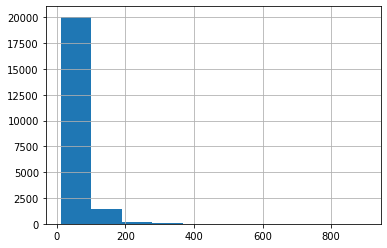

In [55]:
data['total_area'].hist(bins = 10)

Видно что: 
- превалирующее большинство квартир имеет общую площадь до 100 м2 (около 20000 тыс объявлений).
- далее идет спад (от 100 до 380-400 м2)
- в датафрейме нет объявлений с площадью более 400 м2. 
- выбросов за пределами значенией от 0 до 400 м2- нет.

Сделаем 2 гистограммы с разными параметрами - с площадью от 0 до 99 м2 и от 100м2 до 400м2. 

На гистограмме с площадью квартир от 0 до 99 м² видно, что: 
- Больше всего представлено квартир с площадью от `40 до 48 м²` (пик примерно на 45м2 - около 2100 квартир, далее `40м²` - чуть больше 2000 шт.) Также популярны квартиры от `30 до 40 м²` - от 1750 до 1900 предложений. 
- Распределние на гистограмме близко к нормальному- резкий рост от `20 до 40 м²`, пик и далее спад от `50 до 100 м2`. В среднем, квартир площадью `60м²` - около 1350 шт., `70м²`- чуть более 750 шт., `80м²`- около 500, `90м² и 99м²`- около 300. 
- Есть крайне небольшое количество квартир с площадью от `12 до 20м²`. <a id='total_area'></a>

<AxesSubplot:>

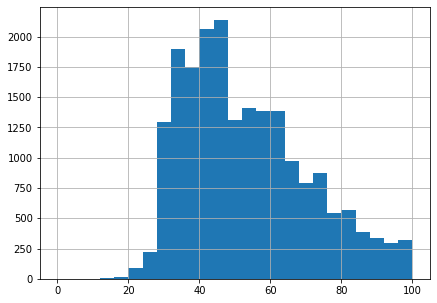

In [56]:
data['total_area'].hist(bins = 25, range = (0, 100), figsize = (7, 5))

Рассмотрим гистограмму площади квартир от 100м². 
Здесь мы видим пиковое значение от 100м² до 110 м² -чуть более 600 предложений, далее гистограмма идет на спад (120 м² - 350, 150м² - 150, 200м²- 50 и уже после 250м² количество предложений стремится к нулю- около 25 предложений квартир с площадью 250 м² и далее единичные предложения с площадью квартир от 300 до 400м²)  

<AxesSubplot:>

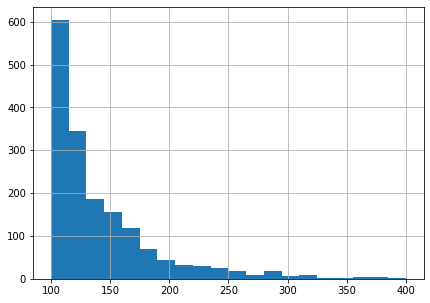

In [57]:
data['total_area'].hist(bins = 20, range = (100, 400), figsize = (7, 5))

Изучив гистограммы площади квартир, можно сделать следующий вывод: 
- Больше всего в продаже квартир с площадью от `30 до 48 м²`
- В сегменте квартир с площадью от `100 до 400 м²` больше всего квартир площадью `100-100 м²`.
- Есть единичные предложения квартир площадью от `12 до 20 м²` и от `300 до 400 м²`

### Стоимость квартиры - `last_price`

Если построить гистограмму по столбцу **last_price** без каких-либо параметров - гистограмма выходит абсолютно неинформативной. Видно резкий пик в районе 0 и ничего более. Так как масштаб такого графика оч мал (от 0 до 8 10⁸), разделим его на секторы и рассмотрим отдельно. Для этого найдем минимальное, максимальное и медианные значения и построим гистограмму исходя из этого. 

<AxesSubplot:>

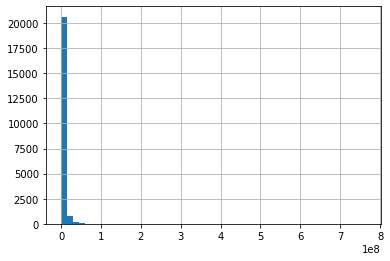

In [58]:
data['last_price'].hist(bins = 50)

In [59]:
print(data['last_price'].min())
print(data['last_price'].max())
data['last_price'].median()

12190
763000000


4650000.0

Рассмотрим гистограмму с квартирами, стоимостью от `0 до 15 млн.` 
- Видно, что имеется явный пик в районе стоимости `4 млн. руб`. - около 2800 предложений. 
- Резкий рост идет в диапазоне от `2 до 4 млн`. руб: 2 млн. - 900 предл., `3 млн.`- 1700, `3,5 млн.`- 2500 шт.
- После 4 млн. гистограмма идет на плавный спад: `5 млн.`- 2000 предложений,`6 млн.` - 1600, `7 млн.` - ок. 800, `8` - 600 шт, `10 млн.` - 300 шт. 
- Количество квартир стомостью от `10 до 15 млн.` практически одинаковое на всем диапазоне и составляет от 300 до 200 шт. 

<AxesSubplot:>

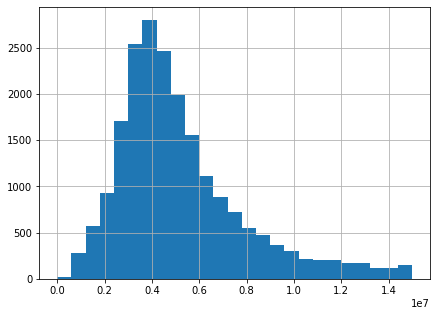

In [60]:
data['last_price'].hist(bins = 25, range = (0, 1.5*10**7), figsize = (7, 5))

Я предполагаю, что из-за масштаба графика мы могли не заметить аномальные значения в районе 0, рассмотрим это подробнее. Построим гистограмму и ограничим ось Х - 1 млн. 
Видно, что есть аномально низкие значения в районе 0 - думаю, это ошибочные объявления и их нужно удалить. 
Также нужно обратить внимание на стоимость от 400 тыс. до 1 млн. - возможно, какие-то из этих объявлений также являются ошибочными. Вернемся к этому в следующем блоке.

<AxesSubplot:>

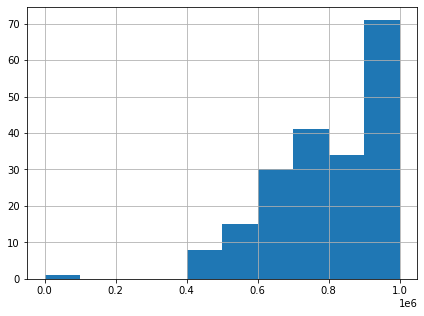

In [61]:
data['last_price'].hist(bins = 10, range = (0, 10**6), figsize = (7, 5))

Если рассмотреть гистограмму стоимости `от 15 млн.` рублей, видим опять же пик в районе 15 млн и далее резкий спад (`20 млн`- 175 предложений, `40 млн`- 25 предложений). 
После стоимости `60 млн.` предложения единичны (не более 10 шт в диапазоне) - эти данные мы также изучим в следующем блоке как редкие. 

<AxesSubplot:>

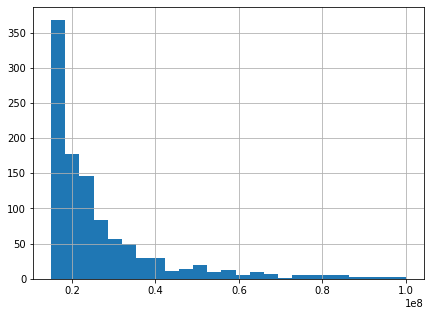

In [62]:
data['last_price'].hist(bins = 25, range = (1.5*10**7, 10**8), figsize = (7, 5))

Вывод по блоку: 
- Больше всего представлено квартир стоимостью `от 3 до 5 млн руб.` (2500-2800 шт. по каждому интервалу)
- Далее идет квартиры стоимостью `от 2 до 3` и `от 5 до 10 млн.` рублей. 
- Дешевле `1 млн.` и дороже `60 млн.`- таких предложений мало и их нужно рассматривать отдельно как возможно неверные. <a id='last_price'></a>

### Число комнат- `rooms`
Рассмотрим гистограмму количества комнат. 
На гистограмме без дополнительных параметров видно, что имеется пик в районе 2-3 комнат и резкий спад после 5 комнат. 
Ось гистограммы идет до 19. Думаю, надо ограничить первую гистограмму 6 комнатами, а вторую- от 6 до 20 и посмотреть результат. 

<AxesSubplot:>

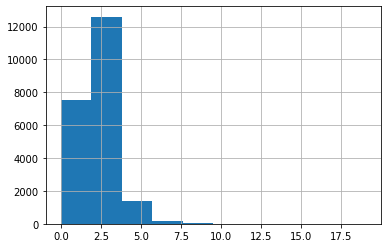

In [63]:
data['rooms'].hist()

На гистограмме с количеством комнат до 6 видно, что: 
- Больше всего представлено однокомнатных и двухкомнатных квартир (чуть более 7000 предложений по каждому)
- Также популярны 3х комнатные квартиры (около 5200 предложений)
- 4х комнатных квартир чуть более 1000, 5-комнатных -около 300 шт. 
- Есть некоторое количество квартир с 0 комнат (ок. 100 шт), рассммотрим этот параметр как редкие/ошибочные данные. <a id='rooms'></a>

<AxesSubplot:>

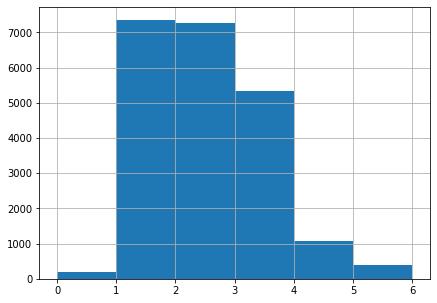

In [64]:
data['rooms'].hist(bins = 6, range = (0, 6), figsize = (7, 5))

На гистограмме с количеством комнат от 6 до 20 видно, что:
- есть пик в районе 6 комнат - чуть менее 100 предложений, 7 комнат- около 50 предложений. 
- далее идет резкий спад и встречаются уже единичные предложения с квартирами, более чем 10 комнат.
Обратим на это внимание. 

<AxesSubplot:>

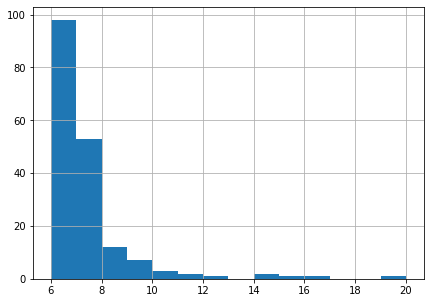

In [65]:
data['rooms'].hist(bins = 14, range = (6, 20), figsize = (7, 5))

Вывод по блоку:
Из гистограмм делаем вывод, что наиболее популярны квартиры с комнатностью от 1 до 5 комнат, лидеры- 1 и 2х комнатные квартиры

### Высота потолков- `ceiling_height`

На гистограмме высоты потолков виден яркий пик на высоте потолков от 2,5 до 3 м., что неудивительно, т.к. здесь проходит и медианное значение высоты потолка. Квартир с такой высотой потолка- ок. 19 тысяч. Даее идет резкий спад и квартир с потолком от 3 до 3,5 м. - уже около 2400. Квартир с высотой потолка более 3,5 м уже настолько мало, что на данном графике рассмотреть не представляется возможным. 

<AxesSubplot:>

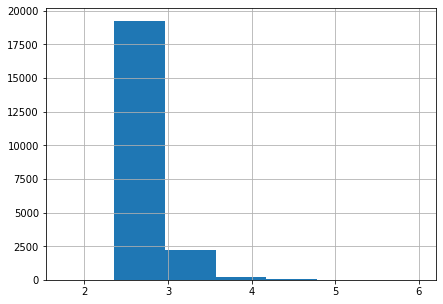

In [66]:
data['ceiling_height'].hist(bins = 7, figsize = (7, 5))

Если постороить график по высоте потолка от 4м, видим, что пик приходится на высоту от 4 до 4,25 м - около 55 значений, далее на высоту от 4,25 до 4,5м - 10-12 значение и далее идут уже единичные значения высоты до 6 м. 

<AxesSubplot:>

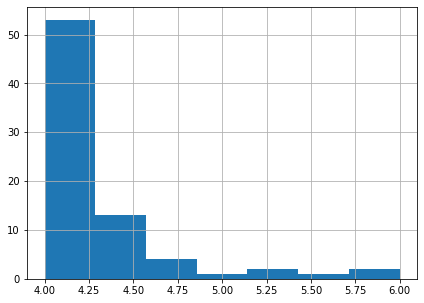

In [67]:
data['ceiling_height'].hist(bins = 7, figsize = (7, 5), range = (4, 6))

### Срок продажи квартиры- `days_exposition`
Для изучения столбца **days_exposition** найдем медианное и среднее значение по столбцу, а затем - выведем список характерных значений при помощи метода `describe` после группировки по столбцу **area**:

In [68]:
print(data['days_exposition'].mean())  #находим среднее значение по столбцу days_exposition
print(data['days_exposition'].median())   #находим медианное значение по столбцу days_exposition

173.3760892618378
99.0


In [69]:
exposition_pivot = data.groupby('area')['days_exposition'].describe()
exposition_pivot = round(exposition_pivot, 0)
exposition_pivot #создание сводной таблицы days_exposition по категориям

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
город,14526.0,173.0,212.0,1.0,47.0,99.0,203.0,1572.0
область,3535.0,178.0,194.0,3.0,58.0,114.0,208.0,1485.0
пригород,3628.0,168.0,202.0,3.0,45.0,96.0,204.0,1580.0


Видно, что медианное значение срока продажи по всему столбцу совпадает с медианным значением по категории "город". Это значит, что большая часть квартир в Санкт-Петербурге продается в этот срок. Однако среднее значение как и по категории "город", так и по всей таблице - выше медианного значения почти в 2 раза. Это значит, что присутствуют как экстримально малые, так и экстримально большие значения, которые сильно влияют на среднее значение. 

Если рассмотреть таблицу, можно заметить, что быстрее всего продаются квартиры в пригородах Санкт-Петербурга (медианное значение- 96 дней, ниже медианы по всему столбцу.) Это может быть связано с более низкой ценой квартир, в сравнении с Санкт-Петербургом и хорошей транспортной доступностью (в отличие, от области). Однако эту гипотезу стоит проверить далее. Чуть медленее продаются квартиры в Санкт-Петербурге (медиана - 99 дней) и медленее всего- в Ленинградской области (114 дней по медианному значению). 
Однако в каждоим из столбцов есть как и малые (столбец min), так и большие значения срока продажи (столбец max). Не могу считать эти значения ошибочными, т.к. ситуации бывают разные и квартира может продаваться как пару дней, так и пару лет. 

Т.к. если судить по сводной таблице, значения **days_exposition** схожи по всем трем категориям, создадим гистограмму по всему столбцу, без разбивки на категории:

<AxesSubplot:>

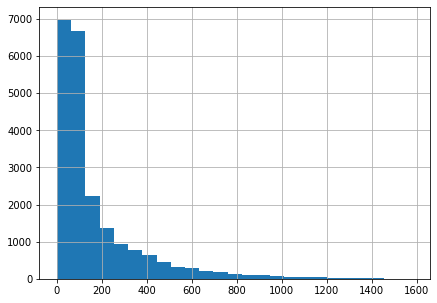

In [70]:
data['days_exposition'].hist(bins = 25, figsize = (7, 5))

Гистограмма подтверждает, что большая часть квартир продается в 100-дневный срок (пиковое значение приходится на период от 0 до 60 дней - около 7000 квартир, от 60 до 120 дней- около 6800 квартир). 
Далее идет резкий спад, однако в период от 120 до 180 дней продается около 2200 квартир. 
Затем гистограмма идет по нисходящей со значениями: 400 дней- 800, 600 дней- 400, 800 дней -200 и далее до единичных значений в районе 1500 дней. <a id='days_exposition'></a>

Таким образом, в среднем около 2/3 квартир  продаются в срок до 120 дней. 

Думаю, что если продажа квартиры вписывается в первый квартиль - она прошла быстро, если в третий- то медленно. Если судить по таблице, порог первого квартиля:
- в пригородах СПб (45 дней), 
- Санкт-Петербурге (47 дней),
- в области (57.5 дней).
Продажи, которые прошли за срок менее первого квартиля- быстрые. 

То же самое, с медленными продажами (3 квартиль): 
- Санкт-Петербург (203 дня)
- пригороды (204 дня)
- область (208 дней)

**Выводы по блоку:**
- Как видно по медианному показателю, быстрее всего продаются квартиры в пригороде Санкт-Петербурга (медианное значение - 96 дней), далее идет Санкт-Петербург (99 дней) и область (114 дней)
- Самая быстрая продажа - в Санкт-Петербурге (1 день), в пригороде и области минимальный срок продажи - 3 дня. 
- Порог быстрых продаж - до 45 дней (пригороды СПб) - 57,5 дней (область).
- Порог медленных продаж - от 203 дней(СПб) до 208 дней (область) и далее. 

### Обработка редких и выбивающихся значений

Уберем редкие и выбивающиеся значения, которые не были убраны в разделе предобработки данных. 
Рассмотрим, как и упоминалось ранее, стобцы [total_area](#total_area), [last_price](#last_price), [rooms](#rooms) и проверим очень долгие продажи по столбцу [days_exposition](#days_exposition).

Начнем со столбца **total_area** и проверим квартиры с площадью менее 20м² и более 300 м². Как видно из запроса, здесь всего 66 строк, что составляет примерно 0,3% от всего общего количества запросов. На самом деле, все эти значения имеют место быть, если мы говорим о Санкт-Петербурге: площадь комнат/студий от 10 до 20м² является типичной для объектов продажи в городе, квартиры более 300м² также редко, но встречаются. Однако для общей картины, думаю, эти данные можно удалить, они не изменят общую картину. 

In [71]:
data.query('total_area<20 or total_area >300').sort_values(by = 'total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area,cost_sq_meter,floor_category,living_total,kitchen_total
19904,4,2400000,12.0,2017-07-19,1,2.55,5,10.0,2,False,...,1.0,886.0,2.0,45.0,200,город,200000.00,другой,0.83,0.00
19807,0,3800000,13.0,2018-07-04,1,2.65,5,10.0,3,False,...,1.0,592.0,3.0,27.0,9,город,292307.69,другой,0.77,0.00
19642,5,1190000,14.0,2018-07-29,1,2.65,5,11.0,1,False,...,0.0,NaN,0.0,NaN,4,город,85000.00,первый,0.79,0.14
8886,10,2450000,15.5,2018-08-22,0,2.65,5,10.0,2,False,...,0.0,NaN,1.0,446.0,27,город,158064.52,другой,0.65,0.00
9412,5,2100000,16.0,2017-12-10,0,2.65,6,13.0,1,False,...,2.0,228.0,3.0,72.0,3,город,131250.00,первый,0.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,1,50000000,517.0,2017-10-14,7,2.65,4,332.0,3,False,...,2.0,477.0,2.0,540.0,99,город,96711.80,другой,0.64,0.04
5358,20,65000000,590.0,2019-02-14,15,3.50,6,409.0,3,False,...,1.0,767.0,0.0,NaN,14,город,110169.49,другой,0.69,0.17
15651,20,300000000,618.0,2017-12-18,7,3.40,7,258.0,5,False,...,0.0,NaN,2.0,198.0,111,город,485436.89,другой,0.42,0.11
12859,20,140000000,631.2,2019-04-09,7,3.90,4,322.3,4,False,...,0.0,NaN,2.0,210.0,99,город,221799.75,последний,0.51,0.03


In [72]:
data = data.query('not(total_area<20 or total_area >300)') #удалим строки с площадью менее 20 и более 300 м2

Теперь перейдем к столбцу **last_price**. Как я писала ранее, стоит проверить квартиры дешевле 1 млн. и дороже 60 млн. рублей. Посмотрим, сколько строк подходят под это условие при помощи запроса. 

Как видно из запроса, под это условие подходят 243 строки, что составляет около 1% от всех строк. 
Если еще раз взглянуть на гистограмму стоимости, видно, что: единичные значения идут до 600 тыс. руб и после 80 млн. руб. Я ограничу запрос именно этими цифрами, т.к. если мы повысим порог минимальной стоимости- потеряем данные о дешевых квартирах в области, если слишком снизим максимум - потеряем в своем исследовании стоимости квартир в центре. 

In [73]:
data.query('last_price < 1000000 or last_price >60000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area,cost_sq_meter,floor_category,living_total,kitchen_total
259,6,900000,30.0,2017-11-21,1,2.50,5,15.0,4,False,...,NaN,NaN,NaN,NaN,114,область,30000.00,другой,0.50,0.17
268,7,650000,46.0,2018-03-15,2,2.50,5,30.0,5,False,...,NaN,NaN,NaN,NaN,75,область,14130.43,последний,0.65,0.15
293,2,900000,42.8,2017-06-14,2,2.65,5,32.0,5,False,...,NaN,NaN,NaN,NaN,247,область,21028.04,последний,0.75,0.12
464,15,66571000,280.3,2015-06-11,6,5.20,8,159.5,7,False,...,3.0,187.0,1.0,616.0,578,город,237499.11,другой,0.57,0.08
492,18,95000000,216.0,2017-12-05,4,3.00,5,86.0,4,False,...,2.0,138.0,3.0,620.0,14,город,439814.81,другой,0.40,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23153,9,650000,41.0,2017-10-13,2,2.65,3,28.0,1,False,...,NaN,NaN,NaN,NaN,14,область,15853.66,первый,0.68,0.15
23354,18,900000,42.6,2018-02-26,2,2.65,2,28.0,1,False,...,NaN,NaN,NaN,NaN,219,область,21126.76,первый,0.66,0.21
23484,11,470000,44.5,2018-07-02,2,2.65,2,28.0,2,False,...,NaN,NaN,NaN,NaN,298,область,10561.80,последний,0.63,0.17
23574,14,64990000,139.0,2015-11-24,3,3.00,8,3.0,8,False,...,1.0,630.0,3.0,100.0,280,город,467553.96,последний,0.02,0.12


In [74]:
data.query('last_price < 600000 or last_price > 80000000')['last_price'].count() #считаем количество

58

In [75]:
data = data.query('not(last_price < 600000 or last_price > 80000000)')

В столбце **rooms** проверим столбцы с 0 комнат и с числом комнат, более 10

In [76]:
data.query('rooms <1 or rooms > 10').sort_values(by = 'rooms')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,area,cost_sq_meter,floor_category,living_total,kitchen_total
144,1,2450000,27.00,2017-03-30,0,2.65,24,15.5,2,False,...,NaN,NaN,NaN,NaN,181,пригород,90740.74,другой,0.57,0.00
16130,14,5000000,42.10,2018-04-13,0,2.65,20,30.0,10,False,...,0.0,NaN,0.0,NaN,170,город,118764.85,другой,0.71,0.00
16144,7,2500000,22.30,2019-01-11,0,2.65,21,18.0,7,False,...,NaN,NaN,NaN,NaN,4,пригород,112107.62,другой,0.81,0.00
16429,2,2460000,28.01,2017-08-17,0,2.65,17,18.1,5,False,...,NaN,NaN,NaN,NaN,15,пригород,87825.78,другой,0.65,0.00
16521,13,3600000,32.80,2017-07-17,0,2.80,16,23.2,4,False,...,1.0,472.0,0.0,NaN,169,город,109756.10,другой,0.71,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7625,5,3450000,25.00,2019-03-05,0,2.65,19,18.0,14,False,...,0.0,NaN,2.0,113.0,99,город,138000.00,другой,0.72,0.00
648,3,17500000,183.70,2018-07-01,11,3.40,7,138.8,7,False,...,0.0,NaN,0.0,NaN,99,город,95264.02,последний,0.76,0.07
9688,8,33000000,194.10,2017-02-07,11,3.43,5,129.0,2,False,...,1.0,686.0,2.0,66.0,813,город,170015.46,другой,0.66,0.06
20829,6,28659000,245.40,2016-03-31,14,2.65,4,168.3,2,False,...,3.0,541.0,2.0,118.0,95,город,116784.84,другой,0.69,0.11


Видно, что под этот запрос подходит 180 квартир. Если изучить таблицу, то видно, что объявления с 0 комнат- это объявления о продаже студий и они вполне реальны. Думаю, эти данные не стоит удалять. 
Если мы еще раз посмотрим на гистограмму. то увидим, что идет резкий спад после количества комнат, более или равному 8. Сделаем такой запрос и увидим, что такх объявлений- 10 строк. Удалим их, как редкие

In [77]:
data.query('rooms > 8')['rooms'].count()
data = data.query('not(rooms > 8)')

Редкие и выбивающиеся значения удалены, проверим все-таки слишком долгие продажи по столбцу **days_exposition** - например, более 600 дней: 

In [78]:
data.query('days_exposition > 600')['rooms'].count()

1116

In [79]:
data.query('days_exposition > 1200')['rooms'].count()

83

Как видно из запроса, квартир, которые были в продаже более, чем 600 дней- 1116 шт, более чем 1200 - 83 шт. Предлагаю оставить этот столбец, как есть - считаю его в ходе данной работы не самым существенным (т.к. основная цель- это все-таки исследование зависимости стоимости квартир от удаленности), излишне удалять данные не считаю верным. 

Т.к. в процессе анализа редких и выбивающихся значений были удалены данные, сравним размерность "отфильтрованного" датафрейма с тем, что было после блока [предобработки](#predobr) данных. 
Видно, что количество строк уменьшилось всего на 134 строки, что не повлияло на медианные значения основных показателей, если судить по данным сводных таблиц из блока [предобработки](#predobr) данных и из настоящего блока. 

In [80]:
len(data)

21555

In [81]:
data_stat_pivot_new = data.pivot_table(index = 'area', values = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'living_area', 'days_exposition'], aggfunc =  'median')
data_stat_pivot_new 

,ceiling_height,days_exposition,last_price,living_area,rooms,total_area
area,,,,,,
город,2.65,99,5500000,31.2,2,55.00
область,2.65,114,2533531,29.0,2,47.20
пригород,2.65,96,3800000,27.0,2,45.99


### Факторы, влияющие на стоимость квартиры
#### Взаимосвязь стоимости квартиры и ее площади 

Рассмотрим взаимосвязь стоимости квартиры и ее площади.
Построим диаграмму рассеяния, на оси X отложим стоимость квартиры, а на оси Y - площадь.  
<a id='factor'></a>

<AxesSubplot:title={'center':'Зависимость стоимости от общей площади'}, xlabel='last_price', ylabel='total_area'>

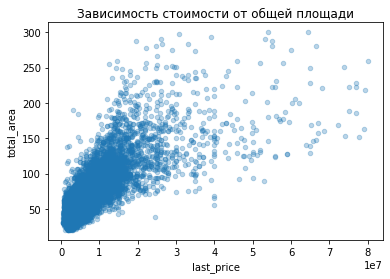

In [82]:
data.plot(x = 'last_price', y = 'total_area', kind = 'scatter', alpha = 0.3, title = ('Зависимость стоимости от общей площади'))

Видно, что график отчетливо возрастает - т.е. с ростом стоимости вырастает и площадь квартиры, можно с уверенностью сказать, что это две величины стремятся к линейной зависимости. Большинство значений находится в диапазоне до 3 млн. рублей и площадью до 125-130 м2, далее предложений становится меньше. но все-таки рост стоимости при росте площади отчетливо виден на графике. 

Ограничим нашу област видимости стоимостью в 10 млн. и площадью до 100м. 
Здесь еще более видна зависимость величин, график уверенно идет вверх. При приближении видно, что большая часть объявлений- на продажу квартир от 20 до 60 м2 со стоимостью от 2 до 6 млн. руб. 

<AxesSubplot:title={'center':'Зависимость стоимости от общей площади'}, xlabel='last_price', ylabel='total_area'>

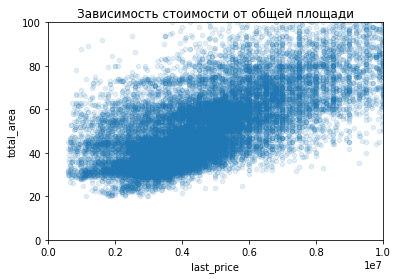

In [83]:
data.plot(x = 'last_price', y = 'total_area', kind = 'scatter', alpha = 0.12, xlim = (0, 10**7), ylim = (0, 100), title = ('Зависимость стоимости от общей площади'))

Если мы посчитаем коэффициент корреляции этих двух величин, то это подтвердит сказанное выше- эти величины зависят друг от друга и с ростом одной- растет и другая. 

In [84]:
data['last_price'].corr(data['total_area'])

0.7643274561121213

#### Взаимосвязь стоимости квартиры и числа комнат

Проверим зависимость стоимости квартиры от числа комнат. 
Для начала создадим диаграмму рассеяния, которая в данном случае оказывается неинформативной. Видно, что с ростом количества комнат растет и цена квартиры, но это не явно. 

<AxesSubplot:title={'center':'Зависимость стоимости от количества комнат'}, xlabel='last_price', ylabel='rooms'>

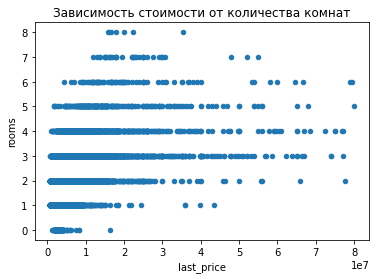

In [85]:
data.sort_values(by = 'rooms').plot(x = 'last_price', y = 'rooms', kind = 'scatter', title = ('Зависимость стоимости от количества комнат'))

Проверка коэффициента корреляции дает нам знать, что эти величины зависимы (хоть и менее, нежели зависимость стоимости от площади). Для визуализации предлагаю сделать сводную таблицу, где мы найдем среднюю стоимость квартир при заданном количестве комнат, а затем построить график. 
<a id='rooms'></a>

In [86]:
data['last_price'].corr(data['rooms'])

0.4748553919003345

In [87]:
data_rooms_price = data.pivot_table(index = 'rooms', values = 'last_price')

<AxesSubplot:xlabel='rooms'>

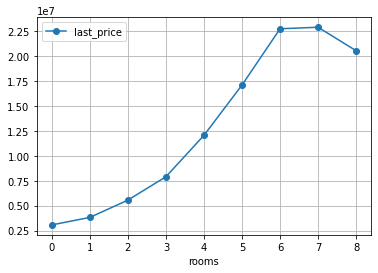

In [88]:
data_rooms_price.plot(style = 'o-', grid = True)

График подтверждает, что с ростом количества комнат растет и стоимость квартиры. Однако этот тграфик подтверждает также то, что ранее было видно на гистограмме - идет спад на квартиры, с количеством комнат более 7. Рост идет вплоть до 6 комнат, на 7-комнатных квартирах рост средней стоимости незначителен, далее идет спад. Думаю, это связано с дороговизной подобных квартир и вынужденным дисконтом для продажи. 

#### Взаимосвязь стоимости квартиры и ее удаленности от центра
Для поиска взаимосвязи стоимости квартиры и ее удаленности создадим столбец **cityCenters_km**, в котором рассчитаем удаленность квартиры от центра в км. Далее построим диаграмму рассеяния по стоимости и удаленности от центра в км. 

По данной диаграмме видно, что стоимость максимальна при удаленности от центра до 10 км. и минимальна- при удаленности от центра более чем 60 км. При проверке коэффицента корреляции видно, что эти величины связаны, но не очень сильно и при росте удаленности от центра стоимость квартиры падает. 

In [89]:
data['cityCenters_km'] = round(data['cityCenters_nearest'] / 1000, 0)

<AxesSubplot:title={'center':'Зависимость стоимости от удаленности от центра'}, xlabel='last_price', ylabel='cityCenters_km'>

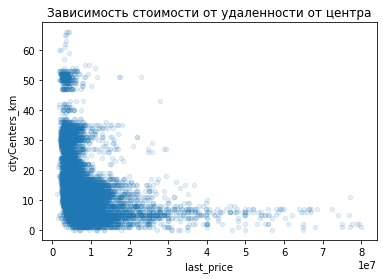

In [90]:
data.plot(x = 'last_price', y = 'cityCenters_km', kind = 'scatter', alpha = 0.12, title = ('Зависимость стоимости от удаленности от центра'))

In [91]:
data['last_price'].corr(data['cityCenters_km'])

-0.3148660345948014

#### Взаимосвязь стоимости квартиры и этажности.
Рассмотрим зависимость стоимости квартиры от этажа, в этом нам поможет столбец **floor_category**. Т.к. здесь есть только 3 категории, делаем сводную таблицу со средним значением стоимости квартиры в каждой категории. Диаграмма рассеяния в этом случае будет малоинформативна и имеет вид такой же, как и в нахождении зависимости между стоимостью квартиры и количеством комнат. <a id='floor'></a>

<AxesSubplot:title={'center':'Зависимость стоимости от этажности'}, xlabel='last_price', ylabel='floor_category'>

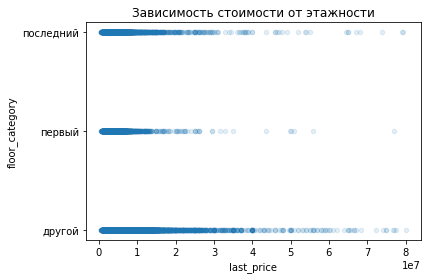

In [92]:
data.plot(x = 'last_price', y = 'floor_category', kind = 'scatter', alpha = 0.12, title = ('Зависимость стоимости от этажности'))

<AxesSubplot:xlabel='floor_category'>

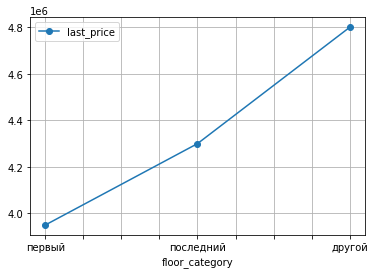

In [93]:
data_price_floor = data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = 'median')
data_price_floor.sort_values(by = 'last_price').plot(style = 'o-', grid = True)

Исследую график видно, что наименее популярен первый этаж - квартиры на первом этаже имеют самую низкую медианную стоимость, далее идет последний этаж и дороже всего- иные этажи, кроме первого и последнего. Это подтверждает зависимость стоимости квартиры от этажа ее расположения. 

#### Взаимосвязь стоимости квартиры и дня/месяца/года размещения
Проверим взаимосвязь стоимости квартиры и дня/месяца/года размещения. Для этого создадим 3 столбца: **weekday**, **month**, **year**, где будут указаны день недели, месяц и год размещения, а потом проанализируем при помощи графиков. 

In [94]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Если посмотреть на коэффициент корреляции, можно увидеть, что зависимости между стоимостью квартиры и днем продажи практически нет, однако коэффициент отрицательный, т.е. с ростом дня недели убывает стоимость квартиры. 
График это подтверждает- выше всего стоимость объявлений, поданных во вторник и среду, ниже всего - с пятницы по воскресенье. <a id='day'></a> 

-0.012601627487513072

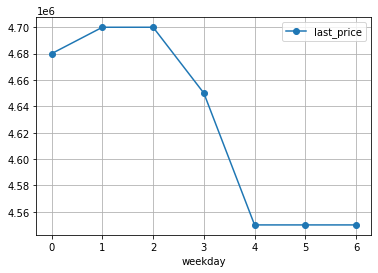

In [95]:
data_price_weekday = data.pivot_table(index = 'weekday', values = 'last_price', aggfunc = 'median')
data_price_weekday.plot(style = 'o-', grid = True)

data['last_price'].corr(data['weekday'])

Между месяцем размещения и стоимостью продажи опять же практически отсутствует взаимосвязь, но если смотреть по графику, медианная стоимость продажи выше всего в апреле и декабре, ниже всего - в июне.
<a id='month'></a>

0.0013615070832963979

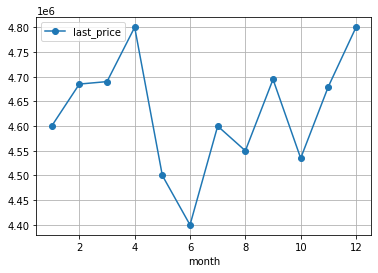

In [96]:
data_price_month = data.pivot_table(index = 'month', values = 'last_price', aggfunc = 'median')
data_price_month.plot(style = 'o-', grid = True)

data['last_price'].corr(data['month'])

Между годом и стоимостью продажи так же нет взаимосвязи. Графи показывает, что пиковая медианная стоимость продажи квартир была в 2014 г., далее стоимость резко упала с минимумом в 2016 и в 2017 гг, а с 2018 г. стала расти, но пока не достигла пиковых значений 2014 г. <a id='year'></a>

-0.05122780478105689

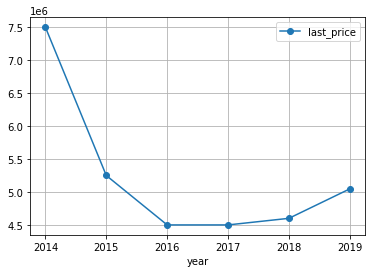

In [97]:
data_price_year = data.pivot_table(index = 'year', values = 'last_price', aggfunc = 'median')
data_price_year.plot(style = 'o-', grid = True)

data['last_price'].corr(data['year'])

**Вывод по блоку**: 
Выяснено, что самое большое влияние на стоимость квартиры оказывают следующие факторы: 
- Общая площадь (чем больше площадь- тем дороже квартира)
- Количество комнат (больше комнат- дороже квартира, но это справедливо для квартир с количеством комнат до 7 включительно)
- Удаленность от центра (чем дальше, тем дешевле)
- Этаж квартиры (дешевле всего квартиры на первом этаже, далее- на последнем). 

Между стоимостью квартиры и датой публикации объявления взаимосвязь отсутствует, однако лучше не публиковать объявления в выходные июньские дни) <a id='conclusion'></a>

### Самые популярные населенные пункты
Найдем населенные пункты с самым большим числом объявлений и посчитаем среднюю стоимость квадратного метра в них. Сделаем для начала Series с 10 самыми популярными населенными пунктами, а затем сделаем запрос по нахождению населенного пункта в этом series:

In [98]:
popular_city = data['locality_name'].value_counts().head(10)
popular_city

Санкт-Петербург      14424
Мурино                 524
Кудрово                422
посёлок Шушары         402
Всеволожск             371
Пушкин                 342
Колпино                327
посёлок Парголово      301
Гатчина                292
Петергоф               197
Name: locality_name, dtype: int64

In [99]:
data_popular_city = data.query('locality_name in @popular_city.index')
data_popular_city.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,area,cost_sq_meter,floor_category,living_total,kitchen_total,cityCenters_km,weekday,month,year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,99,город,120370.37,другой,0.47,0.23,16.0,3,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,81,пригород,82920.79,первый,0.46,0.27,19.0,1,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,558,город,92785.71,другой,0.61,0.15,14.0,3,8,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,121,город,100000.00,другой,0.32,0.41,8.0,1,6,2018
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,155,пригород,99195.71,другой,0.28,0.39,19.0,3,11,2017


Создадим сводную таблицу по самым популярным населенным пунктам и отсортируем ее по убыванию стоимости квадратного метра. 
Таким образом видно, что самая высокая стоимость квадратного метра среди популярных локаций- в Санкт-Петербурге (112581 руб за м²), наименьшая стоимость среди популярных локаций- в Гатчине (68627 руб за м²). 

In [100]:
data_popular_city.pivot_table(index = 'locality_name', values = 'cost_sq_meter').sort_values(by = 'cost_sq_meter', ascending = False)

,cost_sq_meter
locality_name,
Санкт-Петербург,112581.633457
Пушкин,103388.470760
Кудрово,95646.500877
посёлок Парголово,90442.586645
Мурино,86664.716164
Петергоф,84480.969848
посёлок Шушары,78726.044552
Колпино,75249.775443
Всеволожск,68880.130943


### Поиск центральной зоны
Найдем границу центра города для квартир, которые продаются в Санкт-Петербурге. 
Для этого сделаем запрос по столбцу **locality_name** для квартир, которые находятся в Санкт-Петербурге и построим график зависимости стоимости квартиры от удаленности в километрах. 

,last_price
cityCenters_km,
0.0,2.401028e+07
1.0,1.458608e+07
2.0,1.429827e+07
3.0,1.004705e+07
4.0,1.110107e+07
5.0,1.194526e+07
6.0,1.259802e+07
7.0,1.309549e+07
8.0,9.193972e+06


<AxesSubplot:xlabel='cityCenters_km'>

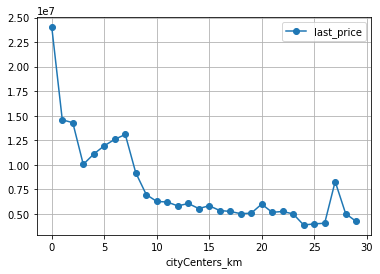

In [101]:
table_city_centre = data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'cityCenters_km', values = 'last_price')
display(table_city_centre.head(10))
table_city_centre.plot(style = 'o-', grid = True)

Видно, что дороже всего квартиры в в самом центре (0 км.), что ожидаемо. Далее идет падение цены, но на расстоянии 2 км. от центра цена все еще высока. Таким образом, можно выделить первый круг центра - до 2 км. Затем на расстоянии от 2 до 7 км. также идет падение стоимости, но средняя стоимость более-менее сохраняется на одном уровне - эту зону и можно назвать радиусом центральной зоны. Далее 7 км. идет резкий спад стоимости. 

Таким образом для исследования очертим диаметр центральной зоны на расстояние 7 км от центра, и самый центр- с радиусом 2 км. 

### Исследование квартир в центре

Посмотрим на параметры квартир в центре. Рассмотрим зону до 2 и до 7 км и проанализируем основные параметры при помощи сводной таблицы. 

In [102]:
data_center = data.query('cityCenters_km <= 7.0').pivot_table(index = 'cityCenters_km', values = ['last_price', 'total_area', 'rooms', 'ceiling_height', 'cost_sq_meter'])
data_center = round(data_center, 2)
data_center

,ceiling_height,cost_sq_meter,last_price,rooms,total_area
cityCenters_km,,,,,
0.0,3.22,225763.42,24010278.55,2.95,104.68
1.0,3.03,142867.55,14586083.33,3.18,97.95
2.0,3.08,146787.52,14298271.71,3.08,97.01
3.0,3.02,117365.20,10047054.20,2.96,86.96
4.0,2.95,127655.94,11101074.90,2.88,87.74
5.0,2.93,134819.95,11945255.21,2.76,87.65
6.0,2.86,142961.29,12598023.25,2.54,83.60
7.0,2.80,150233.38,13095492.89,2.41,77.85


Если проанализировать сводную таблицу, видно, что: 

**в радиусе от 0 до 2 км**:
- Наблюдается наибольшая средняя высота потолков - от 3,08 до 3,22 м. 
- Также наблюдается максимальная стоимость за квадратный метр - ок 226 тыс. руб. за м2 и максимальная средняя стоимость квартиры. 
- следующая по величине средняя стоимость квартиры- на удалении до 2 км от центра. 
- средняя площадь квартиры также велика- от 97 (2 км) до 104,68 м2. 
- среднее количество комнат- 3

**в радиусе от 3 до 7 км**:
- идет общее снижение высоты потолка, но этот параметр еще не доходит до медианного значения (2,65 м.)
- в радиусе от 5 до 7 км. стоимость квадратного метра довольно высока и сравнима с зоной в удалении от 1 до 2 км. от точки отсчета, однако средняя площадь и комнатность квартир снижается, что вкупе дает снижение общей стоимости квартир. 

Все это совпадает с выводами, которые были сделаны [ранее](#conclusion)


Если построить график зависимости средней стоимости продажи квартиры от дня недели публикации объявления, сделав срез по центральной зоне, можно сказать, что здесь, в отличие от общих выводов, стоимость продажи практически не зависит от дня публикации. 
Однако на графике есть резкий минимум в субботу и это падение довольно ощутимо. Если сравнить с [предыдущим](#day) подобным графиком, в нем провал был на пт-вс, здесь же- только в субботу.

<AxesSubplot:xlabel='weekday'>

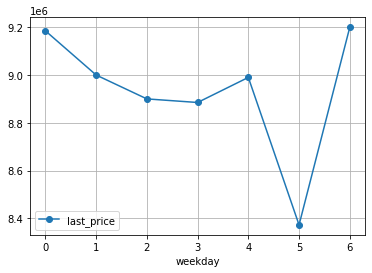

In [103]:
data.query('cityCenters_km <= 7.0').pivot_table(index = 'weekday', values = 'last_price', aggfunc = 'median').plot(style = 'o-', grid = True)


Если изучить график зависимости стоимости жилья в центре от месяца публикации, [выводы](#month) можно сделать иные, нежели в предыдущем подобном графике. Здесь пиковый месяц- это январь, а месяцы наименьших продаж- октябрь и декабрь. Май и июнь также можно отнести к неактивным месяцам.

<AxesSubplot:xlabel='month'>

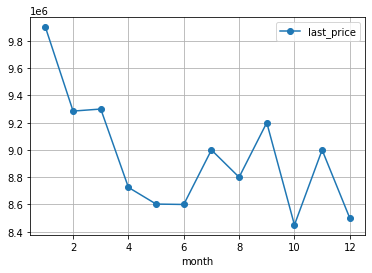

In [104]:
data.query('cityCenters_km <= 7.0').pivot_table(index = 'month', values = 'last_price', aggfunc = 'median').plot(style = 'o-', grid = True)

Стоимость жилья также, как и в прошлом [графике](#year) была пиковой в 2014 году, затем упала. Однако по сравнению с прошлым графиком здесь не было периода стагнации в 2017-2018 г., а падение продолжалось вплоть до 2018 г., затем стоимость незначительно выросла

<AxesSubplot:xlabel='year'>

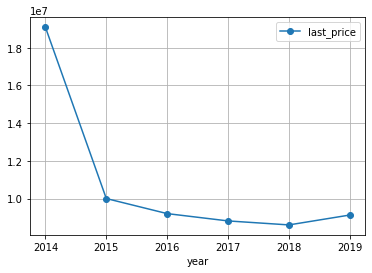

In [105]:
data.query('cityCenters_km <= 7.0').pivot_table(index = 'year', values = 'last_price', aggfunc = 'median').plot(style = 'o-', grid = True)

Проверим также зависимость стоимости квартир в центре от основных параметров (площадь, число комнат, этажность), по аналогии c предыдущим [блоком](#factor).
#### Взаимосвязь стоимости квартиры в центре от ее площади

Построим диаграмму рассеяния зависимости стоимости квартиры от ее площади, но зададим фильтр, определяющий центр города: **cityCenters_km <= 7.0**

**Видно, что общий вид диаграммы рассеяния кардинально не изменился и общая зависимость цены от общей площади квартиры подтвердилась и в центре города.**

Как видно по диаграмме рассеяния, стоимость квартиры растет при росте площади. Больше всего предложений в центре- со стоимостью до 20 млн. руб. и площадью до 150 м2. 
Предложений стоимостью от 20 до 40 млн. руб и с площадью от 150 до 200м2 также немало, но меньше, чем с предыдущими параметрами. 


<AxesSubplot:title={'center':'Зависимость стоимости от общей площади'}, xlabel='last_price', ylabel='total_area'>

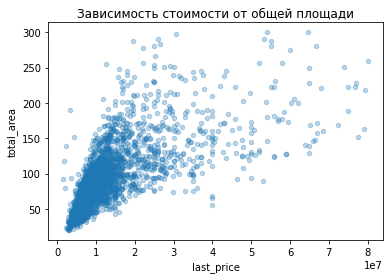

In [106]:
data.query('cityCenters_km <= 7.0').plot(x = 'last_price', y = 'total_area', kind = 'scatter', alpha = 0.3, title = ('Зависимость стоимости от общей площади'))

#### Взаимосвязь стоимости квартиры в центре от числа комнат.

Проверим, подтверждается ли в центре взаимосвязь стоимости квартиры и числа ее комнат. По аналогии с предыдущим разделом не будем делать диаграмму рассеяния, а сразу перейдем в графику по сводной таблице. Здесь также построим применим фильтр для датафрейма на квартиры, расположенные в центре.
Если посмотреть на аналогичный график, построенный по данным из [всего](#rooms) датафрейма, то видим, что: 
- Подтверждается зависимость роста стоимости квартир от увеличения количества комнат
- Графиики идут одинаково до количества комнат (rooms = 6)

После 6 комнат графики отличаются: в графике по всему датафрейму спад идет после 7 комнат, у квартир в центре- наблюдается резкий спад после 6 комнат. Могу связать это с тем, что квартиры с большой комнатностью малопопулярны вследствие их стоимости, поэтому на такие квартиры делают дисконт и средняя цена падает. 

<AxesSubplot:xlabel='rooms'>

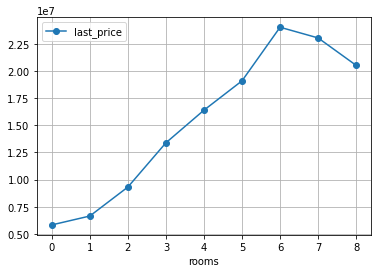

In [107]:
data.query('cityCenters_km <= 7.0').pivot_table(index = 'rooms', values = 'last_price').plot(style = 'o-', grid = True)

#### Взаимосвязь стоимости квартиры в центре от этажности

Построим график зависимости стоимости квартиры от этажности, аналогичный [предыдущему](#floor), но с использованием фильтра на центр. 
Здесь также подтвержается прямая зависимость стоимости от этажности, но вид графика несколько другой. 
Во-первых, видно, что средняя стоимость квартиры вне зависимости от этажа ощутимо выше, нежели при построении графика по всему датафрейму. 
Во-вторых, при сохранении общей тенденции (самый дешевый- первый этаж, далее - последний и, наконец, любой другой), разрыв между этими категориями очень значителен. Если в предыдущем графике разница по стоимости между этажами составляла 10-15%, то здесь мы видим, что:
- Дешевле всего- первый этаж.
- Далее идет последний этаж, однако разрыв в средней стоимости между первым и последним этажом- ок. 40%, а не 10%, как на прошлом графике. 
- Дороже всего- иной этаж кроме первого и последнего, здесь разрыв не так велик и составляет около 5% от средней стоимости. 
Таким образом, здесь нельзя сказать, что квартиры на последнем этаже в центре ощутимо дешевле квартир на иных этажах. Но можно точно сказать, что квартиры на первом этаже в центре существенно дешевле среди иных предложений. 

<AxesSubplot:xlabel='floor_category'>

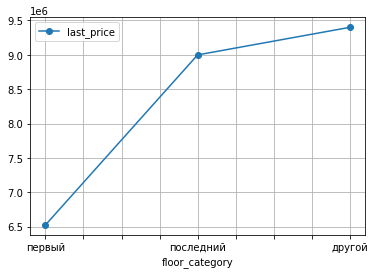

In [108]:
data.query('cityCenters_km <= 7.0').pivot_table(index = 'floor_category', values = 'last_price', aggfunc = 'median').sort_values(by = 'last_price').plot(style = 'o-', grid = True)

**Вывод по блоку**
Изучив основные параметры квартир в центральной зоне (до 7 км.) можно сказать, что основные зависимости стоимости квартир от таких параметров как: площадь квартиры, количество комнат, удаленность от центра - совпадают с ранее сделанными выводами. 

Имеется несовпадение графиков с зависимостью стоимости квартиры от дня и месяца публикации, однако ранее было выяснено, что эти параметры не зависят друг от друга. 
Если посмотреть среднюю стоимость квартир по году, то здесь графики очень схожи. 

## Вывод

В ходе проекта были исследованы гипотезы о зависимости стоимости квартир в Санкт-Петербурге и Ленинградской области от основных параметров: площадь квартиры, количество комнат, удаленность от центра. Была подтверждена зависимость стоимости от данных параметров, построены графики и диаграммы рассеяния, подтверждающие эту гипотезу. Зависимость стоимости квартиры от даты публикации объявления- не подтверждена графиками и расчетами. 

Было найдено 10 самых популярных населенных пунктов, среди которых городом с самой дорогой ценой квадратного метра оказался Санкт-Петербург (112581 руб за м²), а городом с самой дешевой- Гатчина (68627 руб за м²). 

Также была исследована средняя стоимость квадратного метра в Санкт-Петербурге и найден ареал центра - круг с радиусом в 7 км. В этой области была также выделена подобласть с радиусом 2 км., и для найденного ареала были также подтверждены ранее исследуемые гипотезы по зависимости стоимости квартиры от параметров жилья. 

